<a href="https://colab.research.google.com/github/Azeemahma/Reinforcement-Learning/blob/master/Acrobat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode: 100, Epsilon: 0.95, Best Reward: -495.0, Mean Rewards -1942.6
Episode: 200, Epsilon: 0.90, Best Reward: -445.0, Mean Rewards -1691.8
Episode: 300, Epsilon: 0.85, Best Reward: -319.0, Mean Rewards -1465.2
Episode: 400, Epsilon: 0.80, Best Reward: -319.0, Mean Rewards -1201.4
Episode: 500, Epsilon: 0.75, Best Reward: -319.0, Mean Rewards -1081.8
Episode: 600, Epsilon: 0.70, Best Reward: -307.0, Mean Rewards -960.8
Episode: 700, Epsilon: 0.65, Best Reward: -220.0, Mean Rewards -782.6
Episode: 800, Epsilon: 0.60, Best Reward: -220.0, Mean Rewards -708.1
Episode: 900, Epsilon: 0.55, Best Reward: -220.0, Mean Rewards -679.4
Episode: 1000, Epsilon: 0.50, Best Reward: -220.0, Mean Rewards -581.3
Episode: 1100, Epsilon: 0.45, Best Reward: -220.0, Mean Rewards -640.5
Episode: 1200, Epsilon: 0.40, Best Reward: -220.0, Mean Rewards -593.6
Episode: 1300, Epsilon: 0.35, Best Reward: -166.0, Mean Rewards -549.1
Episode: 1400, Epsilon: 0.30, Best Reward: -166.0, Mean Rewards -508.5
Episode: 1

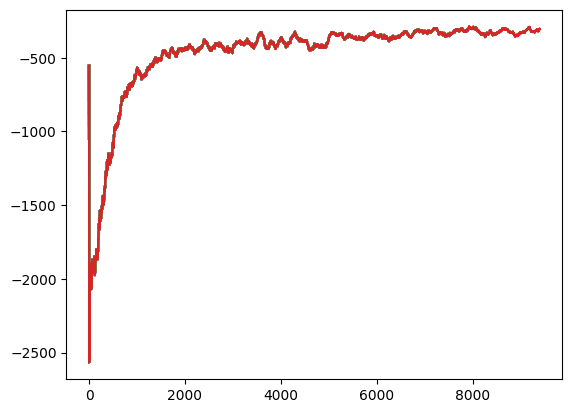

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(is_training=True, render=False):


    env = gym.make('Acrobot-v1', render_mode='human' if render else None)

    # hyperparameters
    learning_rate_a = 0.1        # alpha aka learning rate
    discount_factor_g = 0.9      # gamma aka discount factor.
    epsilon = 1                  # start episilon at 1 (100% random actions)
    epsilon_decay_rate = 0.0005  # epsilon decay rate
    epsilon_min = 0.05           # minimum epsilon
    divisions = 15               # used to convert continuous state space to discrete space

    # Divide continuous observation space into discrete segments
    th1_cos  = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    th1_sin  = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    th2_cos  = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    th2_sin  = np.linspace(env.observation_space.low[3], env.observation_space.high[3], divisions)
    th1_w    = np.linspace(env.observation_space.low[4], env.observation_space.high[4], divisions)
    th2_w    = np.linspace(env.observation_space.low[5], env.observation_space.high[5], divisions)

    if(is_training):
        # initialize q table to 15x15x15x15x15x15x3 array. 16 = division of 15 plus 1 extra slice
        q = np.zeros((len(th1_cos)+1, len(th1_sin)+1,
                      len(th2_cos)+1, len(th2_sin)+1,
                      len(th1_w)+1, len(th2_w)+1,
                      env.action_space.n))
    else:
        f = open('acrobot.pkl', 'rb')
        q = pickle.load(f)
        f.close()


    best_reward = -999999        # track best reward
    rewards_per_episode = []     # list to store rewards for each episode
    i = 0                        # episode counter

    while(True):

        state = env.reset()[0]      # Starting position

        # Convert continuous state to discrete state
        s_i0  = np.digitize(state[0], th1_cos)
        s_i1  = np.digitize(state[1], th1_sin)
        s_i2  = np.digitize(state[2], th2_cos)
        s_i3  = np.digitize(state[3], th2_sin)
        s_i4  = np.digitize(state[4], th1_w)
        s_i5  = np.digitize(state[5], th2_w)

        terminated = False          # True when reached goal
        rewards=0                   # rewards collected per episode

        # Episode
        while(not terminated):

            if is_training and np.random.rand() < epsilon:
                # Choose random action
                action = env.action_space.sample()
            else:
                # Choose best action
                action = np.argmax(q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5, :])

            # Take action
            new_state,reward,terminated,_,_ = env.step(action)

            # Convert continuous state to discrete space
            ns_i0  = np.digitize(new_state[0], th1_cos)
            ns_i1  = np.digitize(new_state[1], th1_sin)
            ns_i2  = np.digitize(new_state[2], th2_cos)
            ns_i3  = np.digitize(new_state[3], th2_sin)
            ns_i4  = np.digitize(new_state[4], th1_w)
            ns_i5  = np.digitize(new_state[5], th2_w)

            # Update Q table
            if is_training:
                q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5, action] += \
                    learning_rate_a * (
                        reward +
                        discount_factor_g * np.max(q[ns_i0, ns_i1, ns_i2, ns_i3, ns_i4, ns_i5,:]) -
                        q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5, action]
                    )

            # Set state to new state
            state = new_state
            s_i0 = ns_i0
            s_i1 = ns_i1
            s_i2 = ns_i2
            s_i3 = ns_i3
            s_i4 = ns_i4
            s_i5 = ns_i5

            # Collect rewards
            rewards+=reward

        if rewards>best_reward:
            best_reward = rewards

            # Save Q table to file on new best reward
            if is_training:
                f = open('acrobot.pkl','wb')
                pickle.dump(q, f)
                f.close()

        # Store rewards per episode
        rewards_per_episode.append(rewards)

        # Print stats
        if is_training and i!=0 and i%100==0:
            # Calculate mean reward over the last 100 episodes
            mean_reward = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
            print(f'Episode: {i}, Epsilon: {epsilon:0.2f}, Best Reward: {best_reward:0.1f}, Mean Rewards {mean_reward:0.1f}')

            # Graph mean rewards
            mean_rewards = []
            for t in range(i):
                # Calculate mean reward over the t-100 episodes
                mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
            plt.plot(mean_rewards)
            plt.savefig(f'acrobot.png')

        elif not is_training:
            print(f'Episode: {i} Rewards: {rewards:0.1f}')

        # Stop, if solved
        if best_reward>env.spec.reward_threshold:
            break

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay_rate, epsilon_min)

        # Increment episode counter
        i+=1

    env.close()


if __name__ == '__main__':
    # run(is_training=True, render=False)

    run(is_training=True, render=False)